In [1]:
# Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Load Dataset

df = pd.read_csv("C:/Users/91801/Desktop/Forecasting_Project/dataset/Consumption Dataset.csv")
df.head()

,Date Time Served,Bar Name,Alcohol Type,Brand Name,Opening Balance (ml),Purchase (ml),Consumed (ml),Closing Balance (ml)
0,01-01-2023 19:35,Smith's Bar,Rum,Captain Morgan,2555.04,1824.84,0.0,4379.88
1,01-01-2023 10:07,Smith's Bar,Wine,Yellow Tail,1344.37,0.00,0.0,1344.37
2,01-01-2023 11:26,Johnson's Bar,Vodka,Grey Goose,1034.28,0.00,0.0,1034.28
3,01-01-2023 13:53,Johnson's Bar,Beer,Coors,2194.53,0.00,0.0,2194.53
4,01-01-2023 22:28,Johnson's Bar,Wine,Yellow Tail,1020.90,0.00,0.0,1020.90


In [3]:
# Informatin About Data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6575 entries, 0 to 6574
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date Time Served      6575 non-null   object 
 1   Bar Name              6575 non-null   object 
 2   Alcohol Type          6575 non-null   object 
 3   Brand Name            6575 non-null   object 
 4   Opening Balance (ml)  6575 non-null   float64
 5   Purchase (ml)         6575 non-null   float64
 6   Consumed (ml)         6575 non-null   float64
 7   Closing Balance (ml)  6575 non-null   float64
dtypes: float64(4), object(4)
memory usage: 411.1+ KB


In [4]:
# Describe The Data

df.describe()

,Opening Balance (ml),Purchase (ml),Consumed (ml),Closing Balance (ml)
count,6575.000000,6575.000000,6575.000000,6575.000000
mean,2468.397180,315.841757,299.419264,2484.811748
std,2284.552895,582.120264,191.903874,2302.363298
min,0.000000,0.000000,0.000000,0.000000
25%,619.135000,0.000000,156.640000,611.000000
50%,1848.440000,0.000000,300.390000,1849.840000
75%,3853.020000,526.345000,450.870000,3906.050000
max,11862.520000,1999.840000,1180.580000,11862.520000


In [5]:
# Check For Nulls

df.isnull().sum()

Date Time Served        0
Bar Name                0
Alcohol Type            0
Brand Name              0
Opening Balance (ml)    0
Purchase (ml)           0
Consumed (ml)           0
Closing Balance (ml)    0
dtype: int64

In [6]:
# Standardize Column Names

df.columns = df.columns.str.lower().str.replace(" ","_").str.replace(r"[()]","",regex=True)

In [7]:
# Convert Date Column

df["date"] = pd.to_datetime(df["date_time_served"], format="mixed")
df["date"] = pd.to_datetime(df["date"].dt.date)
df.drop(["date_time_served"], axis=1, inplace=True)

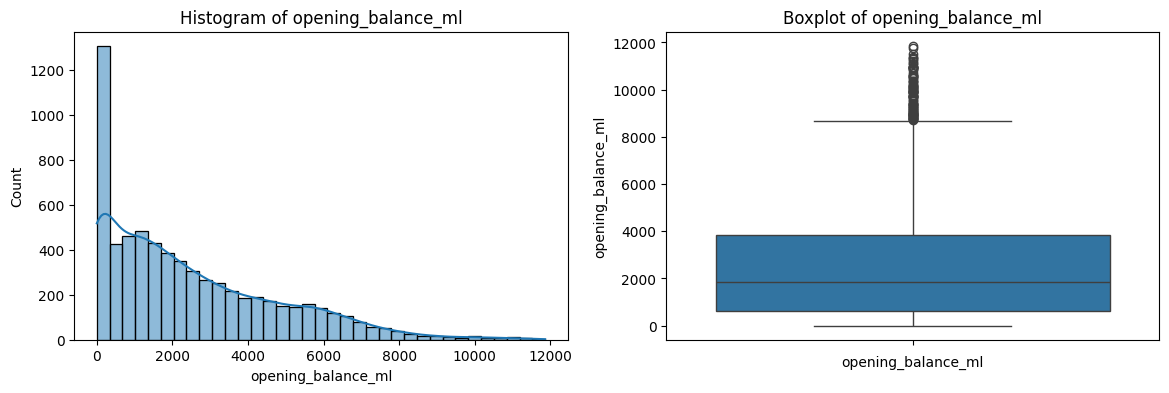

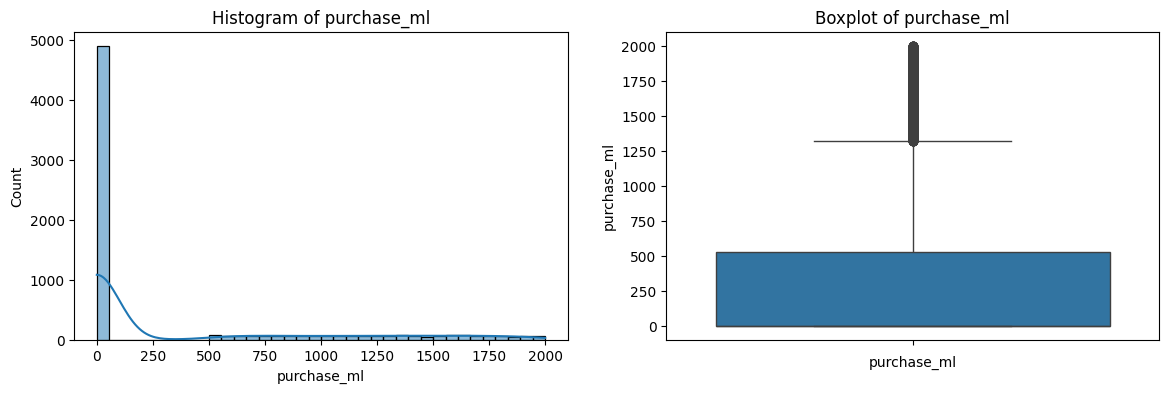

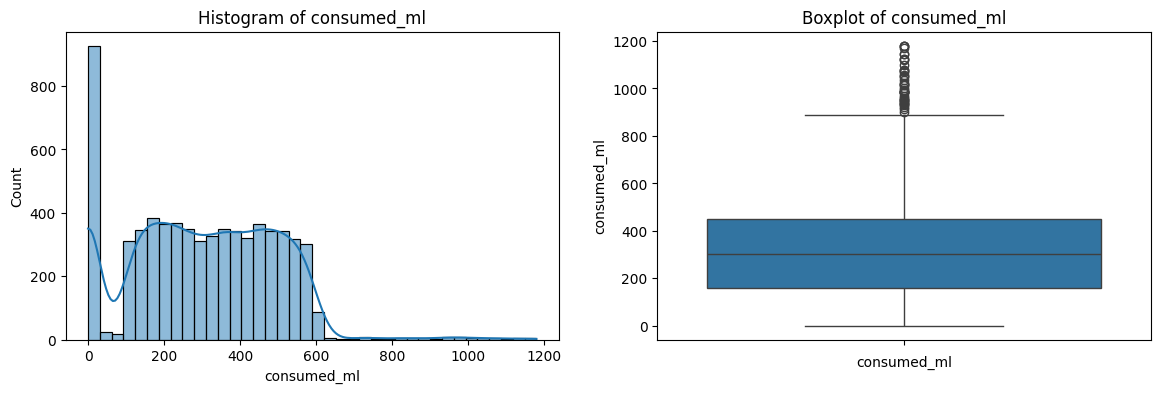

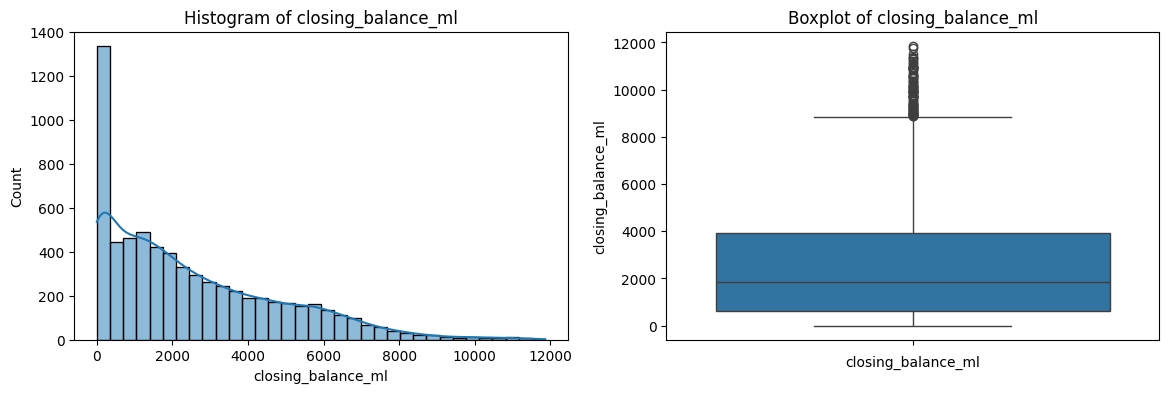

In [8]:
# Exploratory Data Analysis

columns = df.select_dtypes(include="number")
for col in columns:
    plt.figure(figsize=(14, 4))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)

    plt.subplot(1, 2, 2)
    sns.boxplot(df[col])
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    
    plt.show()

<Axes: xlabel='count', ylabel='bar_name'>

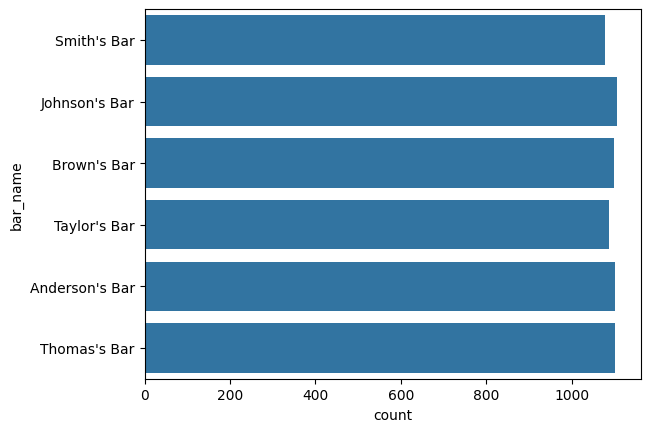

In [9]:
# Count Plots for Categorical Columns

sns.countplot(data=df, y="bar_name")

<Axes: xlabel='alcohol_type', ylabel='count'>

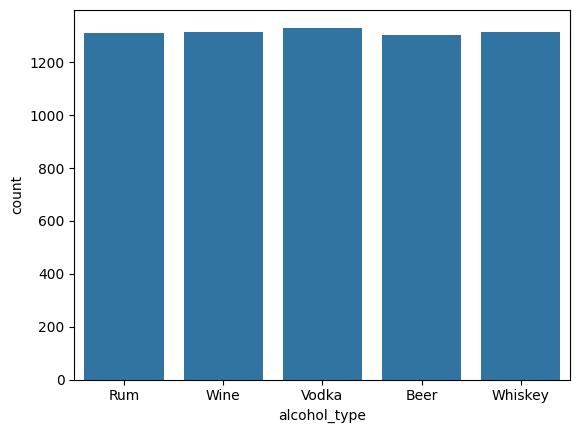

In [10]:
sns.countplot(data=df, x="alcohol_type")

<Axes: xlabel='count', ylabel='brand_name'>

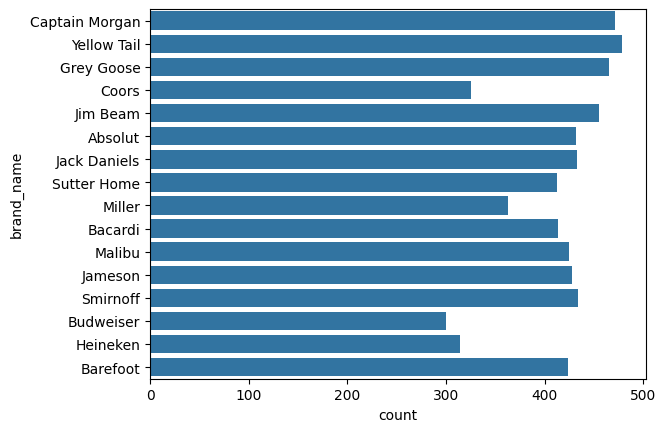

In [11]:
sns.countplot(data=df, y="brand_name")

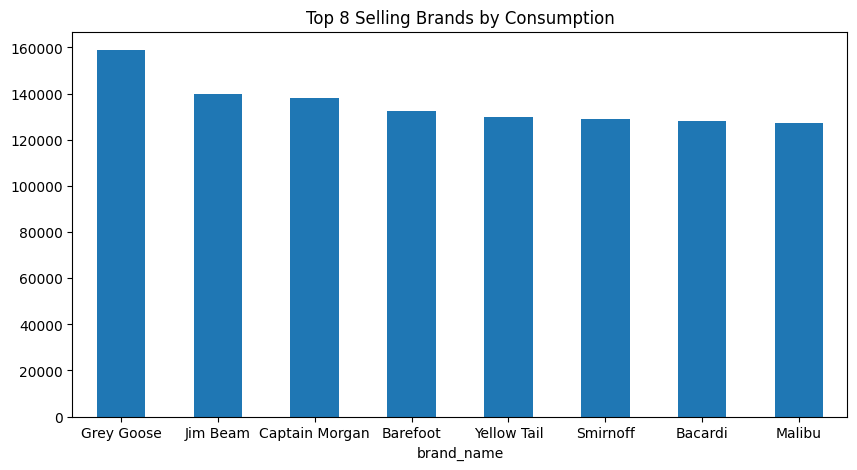

In [12]:
# Top 8 Selling Brands by Total Consumption

top_brands = df.groupby("brand_name")["consumed_ml"].sum().sort_values(ascending=False).head(8)
top_brands.plot(kind="bar", figsize=(10,5), title="Top 8 Selling Brands by Consumption")
plt.xticks(rotation=0)
plt.show()

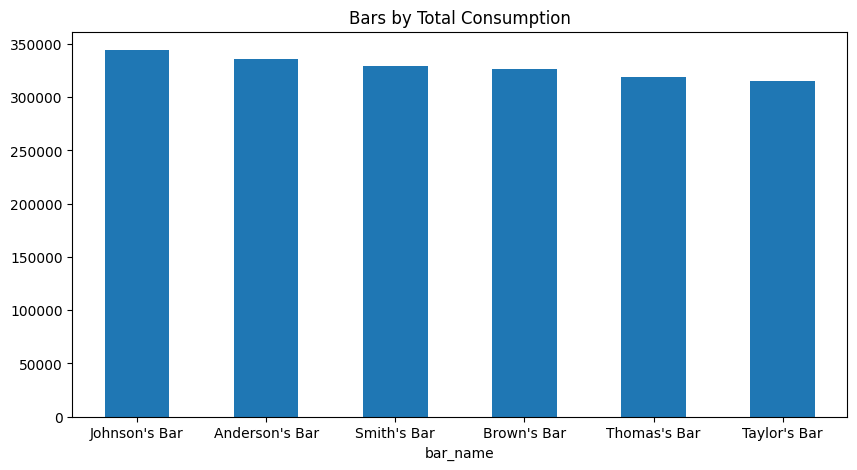

In [13]:
# Bars by Total Consumed

top_bars = df.groupby("bar_name")["consumed_ml"].sum().sort_values(ascending=False)
top_bars.plot(kind="bar", figsize=(10,5), title="Bars by Total Consumption")
plt.xticks(rotation=0)
plt.show()

<Axes: xlabel='date', ylabel='consumed_ml'>

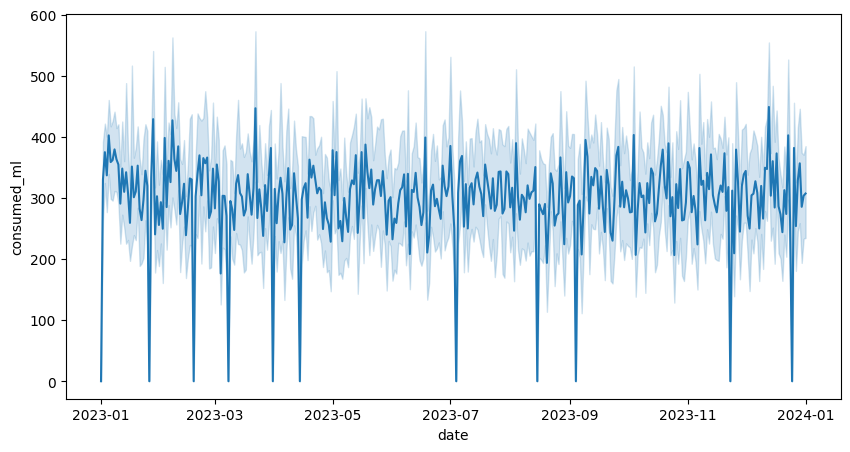

In [14]:
# Most consumption values between 250–400 ml. fairly stable demand throughout the year

plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x="date", y="consumed_ml")

Percentage of zero consumption records: 13.84%


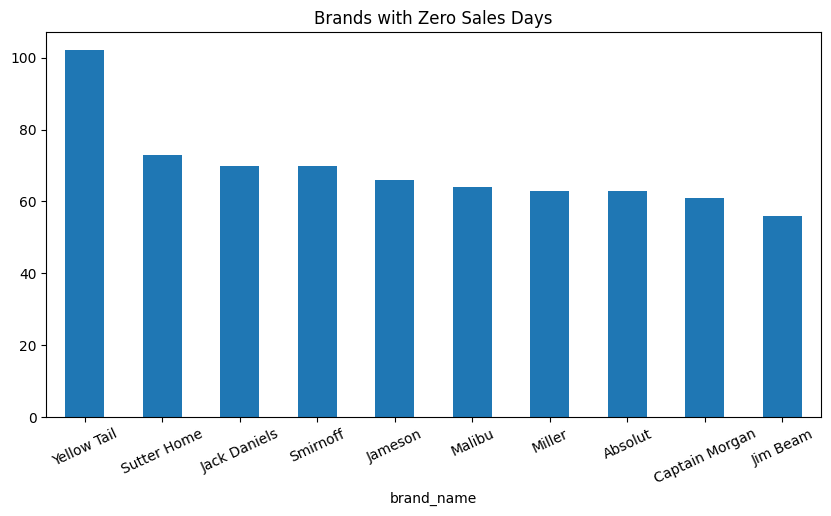

In [15]:
# Brands with Zero Sales Days

zero_sales = df[df["consumed_ml"] == 0]
zero_sales["brand_name"].value_counts().head(10).plot(kind="bar", figsize=(10,5), title="Brands with Zero Sales Days")
plt.xticks(rotation=25)

print(f"Percentage of zero consumption records: {len(zero_sales)/len(df) * 100:.2f}%")

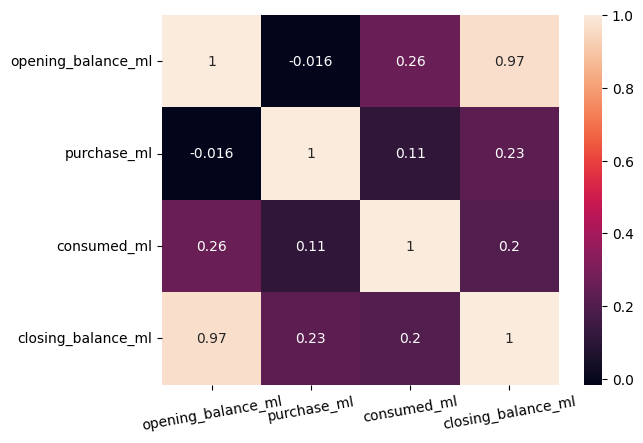

In [16]:
# Large opening balance typically leads to lower purchase quantities
# Higher consumption can drive more purchasing
# opening balance, closing balance - Strong multicollinearity. These two give similar information

sns.heatmap(df.select_dtypes(include="number").corr(), annot=True)
plt.xticks(rotation=10)
plt.show()

In [17]:
# Log Transformation to Handle Skewness

df["opening_balance_ml"] = np.log1p(df["opening_balance_ml"])
df["purchase_ml"] = np.log1p(df["purchase_ml"])

In [18]:
# Feature Engineering

df["month"] = pd.to_datetime(df["date"]).dt.month
df["day"] = pd.to_datetime(df["date"]).dt.day
df["year"] = pd.to_datetime(df["date"]).dt.year
df["dayofweek"] = pd.to_datetime(df["date"]).dt.dayofweek

df["net_change"] = df["purchase_ml"] - df["consumed_ml"]
df["balance_diff"] = df["opening_balance_ml"] - df["closing_balance_ml"]

In [20]:
# Label Encoding for Categorical Features

columns = df[["bar_name", "brand_name", "alcohol_type"]]
for col in columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [21]:
# Define Features and Target

x = df[["bar_name", "brand_name", "alcohol_type", "net_change", "balance_diff", "day", "month", "dayofweek"]]
y = df["consumed_ml"]

In [22]:
# Train-Test Split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [23]:
# load XGBRegressor Model

model = XGBRegressor()

In [24]:
# Train dataset

model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [25]:
# Make Predict Unseen/Test data

y_pred = model.predict(x_test)

In [26]:
# Evaluation Metrics

print(f"Mae : {mean_absolute_error(y_test, y_pred)}")
print(f"Mse : {mean_squared_error(y_test, y_pred)}")
print(f"R2_score : {r2_score(y_test, y_pred)}")

Mae : 3.5707128292633348
Mse : 104.85892728034756
R2_score : 0.9972751170800722


In [27]:
# Cross Validation for Model Evaluation

scores = cross_val_score(model, x_train, y_train, cv=5)
print("Average score:", scores.mean())

Average score: 0.9980764263322239


In [28]:
# Future Forecast Dates and Unique Combinations of Bar & Brand

future_dates = pd.date_range(start="2024-01-01", end="2024-01-07")
unique_brand = df[["bar_name", "brand_name"]].drop_duplicates()

In [48]:
# Predict Future Consumption

future_preds = []

for row in unique_brand.itertuples(index=False):
    bar = row.bar_name
    brand = row.brand_name
    
    past_data = df[(df["bar_name"] == bar) & (df["brand_name"] == brand)].sort_values("date")

    latest_row = past_data.iloc[-1]
    alcohol_type = latest_row["alcohol_type"]
    net_change = latest_row["net_change"]
    balance_diff = latest_row["balance_diff"]

    for date in future_dates:
        features = {
            "bar_name": bar,
            "brand_name": brand,
            "alcohol_type": alcohol_type,
            "net_change": net_change,
            "balance_diff": balance_diff,
            "day": date.day,
            "month": date.month,
            "dayofweek": date.dayofweek
        }

        x = pd.DataFrame([features])
        x = pd.get_dummies(x)
        y_pred = max(0, model.predict(x)[0])

        future_preds.append({
            "bar_name": bar,
            "brand_name": brand,
            "alcohol_type": alcohol_type,
            "date": date,
            "forecasted_consumed_ml": y_pred
        })

forecast_df = pd.DataFrame(future_preds)

In [31]:
# Calculate Par Levels of Total Forecasted Consumption per Day

par_levels = forecast_df.groupby(["bar_name", "brand_name", "alcohol_type", "date"])["forecasted_consumed_ml"].sum().reset_index().rename(columns={"forecasted_consumed_ml": "recommended_ml"})

In [32]:
# Export to EXCEL

par_levels.to_excel("C:/Users/91801/Desktop/Forecasting_Project/dataset/Inventory_Managment.xlsx", index=False)
print("📁 File saved as 'Inventory_Managment.xlsx'")

📁 File saved as 'Inventory_Managment.xlsx'


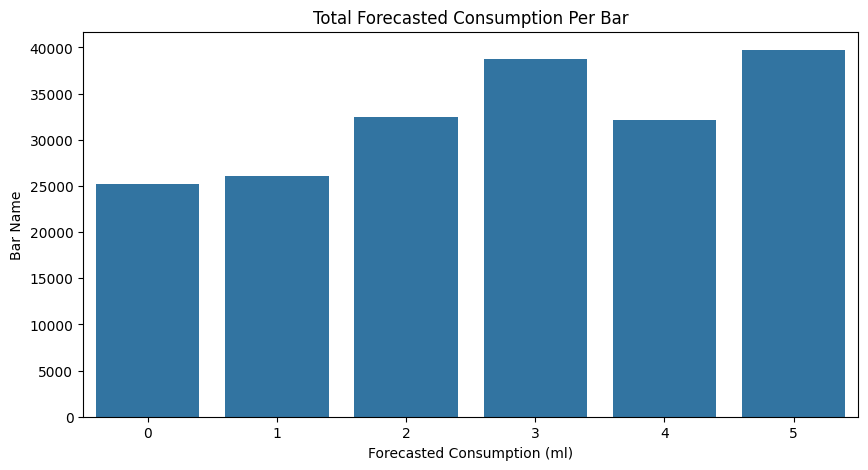

In [55]:
bar_wise = forecast_df.groupby("bar_name")["forecasted_consumed_ml"].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=bar_wise.index, y=bar_wise.values)
plt.title("Total Forecasted Consumption Per Bar")
plt.xlabel("Forecasted Consumption (ml)")
plt.ylabel("Bar Name")
plt.show()

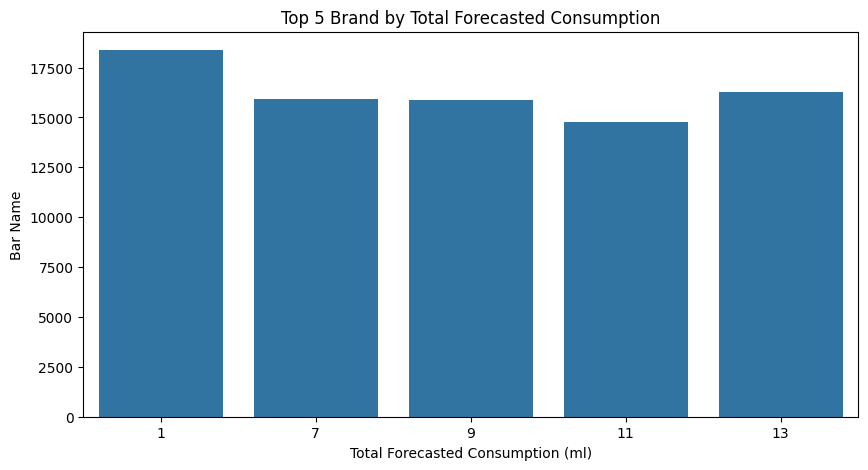

In [54]:
top_brands = (
    forecast_df.groupby("brand_name")["forecasted_consumed_ml"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .reset_index()
)

plt.figure(figsize=(10, 5))
sns.barplot(data=top_brands, y="forecasted_consumed_ml", x="brand_name")
plt.title("Top 5 Brand by Total Forecasted Consumption")
plt.xlabel("Total Forecasted Consumption (ml)")
plt.ylabel("Bar Name")
plt.show()

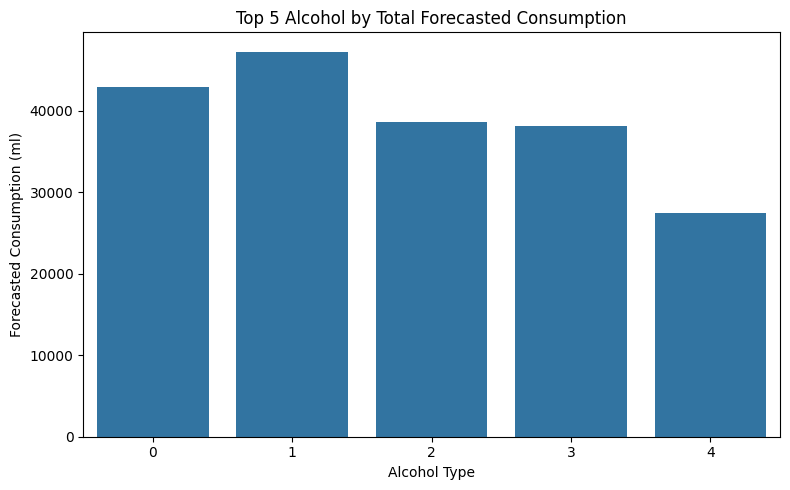

In [52]:
top_alcohol = forecast_df.groupby("alcohol_type")["forecasted_consumed_ml"].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_alcohol.index, y=top_alcohol.values)
plt.title("Top 5 Alcohol by Total Forecasted Consumption")
plt.xlabel("Alcohol Type")
plt.ylabel("Forecasted Consumption (ml)")
plt.tight_layout()
plt.show()

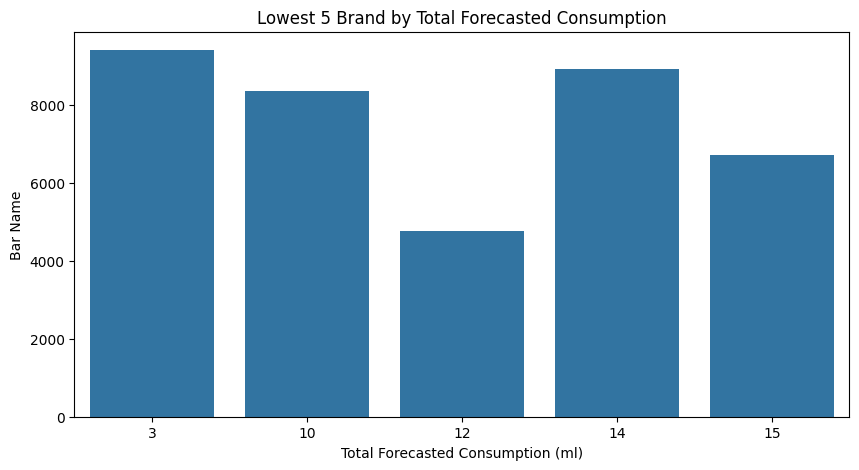

In [50]:
lowest_brands = (
    forecast_df.groupby("brand_name")["forecasted_consumed_ml"]
    .sum()
    .sort_values(ascending=True)
    .head(5)
    .reset_index())

plt.figure(figsize=(10, 5))
sns.barplot(data=lowest_brands, y="forecasted_consumed_ml", x="brand_name")
plt.title("Lowest 5 Brand by Total Forecasted Consumption")
plt.xlabel("Total Forecasted Consumption (ml)")
plt.ylabel("Bar Name")
plt.show()

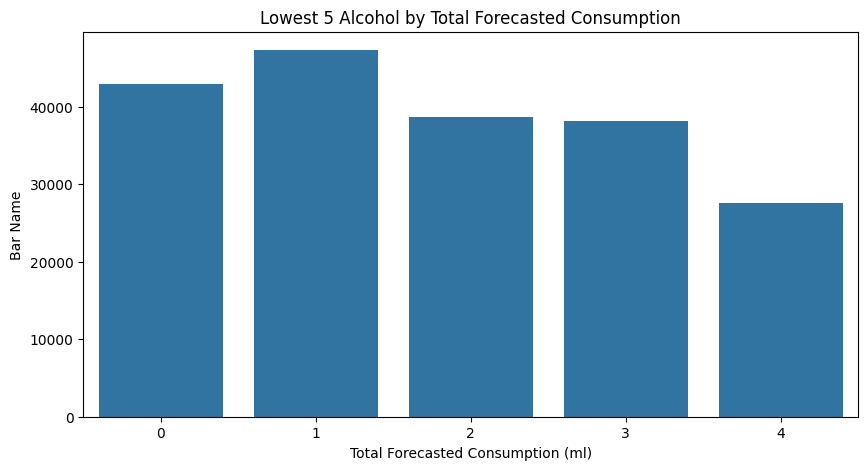

In [51]:
lowest_alcohol = (
    forecast_df.groupby("alcohol_type")["forecasted_consumed_ml"]
    .sum()
    .sort_values(ascending=True)
    .head(5)
    .reset_index())

plt.figure(figsize=(10, 5))
sns.barplot(data=lowest_alcohol, y="forecasted_consumed_ml", x="alcohol_type")
plt.title("Lowest 5 Alcohol by Total Forecasted Consumption")
plt.xlabel("Total Forecasted Consumption (ml)")
plt.ylabel("Bar Name")
plt.show()